In [1]:
import cv2
import math
import os

%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image

from utils.thresholding import *

In [336]:
WIDTH = 640
HEIGHT = 480

# Change these variables based on our car.
wheelbase = 0.1524 # Length of car from front to back in meters
n = 5 # Angle gain

curvature = 1500
is_left_turn = False

ym_per_pix = 0.1524 / 72.0
xm_per_pix = 0.2286 / 600.0
y_eval = 240
midx = 320

#ROI Parameters
y_bottom = HEIGHT
y_top = int(HEIGHT * 0.4)

In [3]:
frame_in_w = WIDTH
frame_in_h = HEIGHT

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


In [561]:
test_image = Image.open(os.path.join('test_images', 'test24.jpg'))
resized_image = np.array(test_image.resize((WIDTH, HEIGHT), Image.BILINEAR))
# ret, frame_vga = videoIn.read()
# resized_image = cv2.cvtColor(frame_vga.reshape(frame_in_h, frame_in_w, 3).astype(np.uint8), cv2.COLOR_BGR2RGB)
b_thresholded = threshold(resized_image)

([], <a list of 0 Text yticklabel objects>)

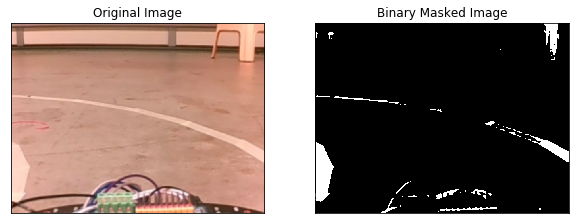

In [562]:
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(resized_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(b_thresholded, cmap="gray")
plt.title('Binary Masked Image')
plt.xticks([])
plt.yticks([])

In [589]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
scale_factor_h = width / 1280
scale_factor_v = height / 720
offset = 200 * scale_factor_h
src = np.float32([
    [100, 100],
    [600, 100],
    [600, 390],
    [40, 390]
])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))#[y_top:y_bottom, :]

([], <a list of 0 Text yticklabel objects>)

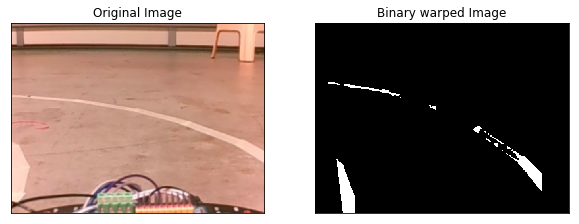

In [590]:
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(resized_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(binary_warped, cmap="gray")
plt.title('Binary warped Image')
plt.xticks([])
plt.yticks([])

In [575]:
kernel = np.ones((20, 20), np.uint8)

# Clean small blobs
binary_cleaned = cv2.morphologyEx(binary_warped, cv2.MORPH_OPEN, kernel)

# Fill small gaps
binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_CLOSE, kernel)

([], <a list of 0 Text yticklabel objects>)

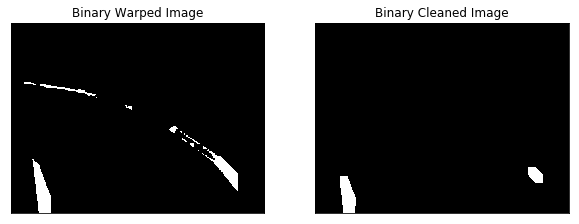

In [576]:
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(binary_warped, cmap="gray")
plt.title('Binary Warped Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(binary_cleaned, cmap="gray")
plt.title('Binary Cleaned Image')
plt.xticks([])
plt.yticks([])

In [577]:
def compute_lane_heading_angle(left_fit=None, right_fit=None, y_eval=200):
    """
    Computes the average heading angle (in degrees) between the vehicle's forward direction (image y-axis)
    and the tangent direction of the lane lines at the bottom of the image (y = y_eval).
    
    Returns a signed angle:
    - Positive → turn right
    - Negative → turn left
    """
    angles = []

    def angle_from_fit(fit):
        # Derivative of the 2nd-order polynomial at y = y_eval
        dy = 1.0  # pixel change in y
        dx = 2 * fit[0] * y_eval + fit[1]  # derivative at y_eval
        angle_rad = np.arctan(dx)  # slope to angle
        return -np.degrees(angle_rad)

    if left_fit is not None:
        angles.append(angle_from_fit(left_fit))
    if right_fit is not None:
        angles.append(angle_from_fit(right_fit))

    if angles:
        print(angles)
        # Average heading angle from both lanes
        return np.mean(angles)
    else:
        return None

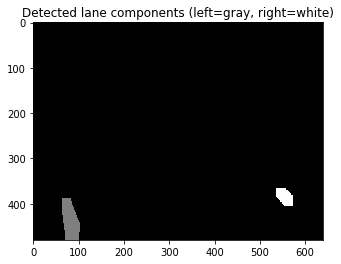

In [583]:
def detect_lane_lines_connected_components(binary_warped):
    # Ensure the input is binary (0 and 255)
    binary = np.uint8(binary_warped * 255) if binary_warped.max() <= 1 else np.uint8(binary_warped)

    # Apply connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Image dimensions
    height, width = binary.shape
    
    # Prepare blank output for visualization or processing
    output = np.zeros_like(binary)

    # Store points
    leftx, lefty, rightx, righty = [], [], [], []

    for i in range(1, num_labels):  # Label 0 is background
        x, y, w, h, area = stats[i]
        cx, cy = centroids[i]

        # Heuristic filters for likely lane lines
        if area > 1000 and h > 30:
            if cx < width // 2:
                output[labels == i] = 127
                coords = np.column_stack(np.where(labels == i))
                for pt in coords:
                    lefty.append(pt[0])
                    leftx.append(pt[1])
            else:
                output[labels == i] = 255
                coords = np.column_stack(np.where(labels == i))
                for pt in coords:
                    righty.append(pt[0])
                    rightx.append(pt[1])

    # Convert lists to numpy arrays
    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty, output

leftx, lefty, rightx, righty, output = detect_lane_lines_connected_components(binary_cleaned)

plt.imshow(output, cmap='gray')
plt.title('Detected lane components (left=gray, right=white)')
plt.show()

In [584]:
if leftx.size > 0 and lefty.size > 0 and rightx.size > 0 and righty.size > 0:
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2]
    x_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    angle = compute_lane_heading_angle(left_fit=left_fit, right_fit=right_fit)
elif leftx.size > 0 and lefty.size > 0:
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = [0,0,0]

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2]
    x_bottom = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    angle = compute_lane_heading_angle(left_fit=left_fit)
elif rightx.size > 0 and righty.size > 0:
    # Fit a second order polynomial to each
    left_fit = [0,0,0]
    right_fit = np.polyfit(righty, rightx, 2)

    y1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    y_top = 0
    y_bottom = y_eval  # typically near 700

    x_top = right_fit[0]*y_top**2 + right_fit[1]*y_top + right_fit[2]
    x_bottom = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2]

    is_left_turn = x_bottom > x_top
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    angle = compute_lane_heading_angle(right_fit=right_fit)

[-46.681694700118868, -43.350998993128307]


In [585]:
print(angle)

-45.0163468466


Text(0.5,1,'Lane Detected')

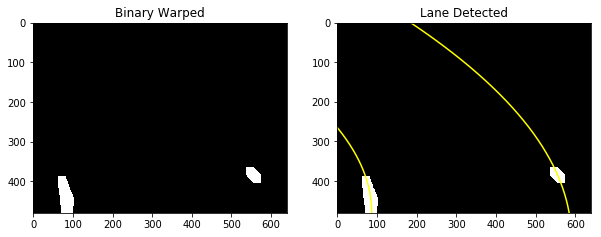

In [586]:
out_img = np.dstack((binary_cleaned, binary_cleaned, binary_cleaned))*255

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_cleaned, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 640)
plt.ylim(480, 0)
plt.title('Lane Detected')